# MNIST Digit Recognition using a Basic Neural Network
This notebook implements a feedforward neural network trained via stochastic gradient descent to classify MNIST digits.

![](http://miro.medium.com/v2/resize:fit:1080/0*d9yJ5xIqdbDyjCYR.gif)

### 1. Neural Networks

A **neural network** is a parametric function inspired by biological neurons. It consists of:

- **Layers** of nodes (neurons):  
  - **Input layer** accepts raw features (here, 784-dimensional vectors for MNIST).  
  - One or more **hidden layers** process intermediate representations.  
  - **Output layer** produces scores or probabilities for each class (10 classes for digits 0–9).  
- **Weights** ($W$) and **biases** ($b$) on each layer, which are adjusted during training.

A single forward-pass through a 2-layer network with a sigmoid hidden layer and a linear output is:

$$
\begin{aligned}
z^{(1)} &= W^{(1)} x + b^{(1)}, &\quad a^{(1)} &= \sigma\bigl(z^{(1)}\bigr), \\
z^{(2)} &= W^{(2)} a^{(1)} + b^{(2)}, &\quad a^{(2)} &= z^{(2)}.
\end{aligned}
$$

Here, the sigmoid activation function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

In [5]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

def load_data():
    with open('/kaggle/input/mnist-dataset/mnist.pkl', 'rb') as f:
        train, val, test = pickle.load(f, encoding='latin1')
    return train, val, test

def vectorized_result(j):
    """Convert a digit (0...9) into a 10-dimensional unit vector."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def load_data_wrapper():
    """Wrap data into the format expected by our neural network code."""
    train, val, test = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in train[0]]
    training_results = [vectorized_result(y) for y in train[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in val[0]]
    validation_data = list(zip(validation_inputs, val[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = list(zip(test_inputs, test[1]))
    return training_data, validation_data, test_data

### 2. Loss Function & Minimization  
We use **cross-entropy loss** via PyTorch’s  
```python
criterion = nn.CrossEntropyLoss()
```

For a single example with one-hot label vector $y$ and network logits $z$ (a vector of raw scores before softmax), the cross-entropy loss is defined as:

$$
L(z, y) = - \sum_{i=1}^{10} y_i \log \big( \text{softmax}(z)_i \big),
$$

where the softmax function converts logits into probabilities:

$$
\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}.
$$

This loss measures the dissimilarity between the predicted probability distribution and the true distribution (one-hot label).

---

### Gradient Descent Update Rule

To minimize the loss, we update the network parameters (weights $W$ and biases $b$) using gradient descent:

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}, \quad
b \leftarrow b - \eta \frac{\partial L}{\partial b},
$$

where $\eta$ is the learning rate, a hyperparameter controlling the step size of updates.

---

## 3. Gradient Descent & Stochastic Gradient Descent (SGD)

### Batch Gradient Descent

- Computes gradients over the **entire training set** at once.
- This can be very slow and computationally expensive for large datasets.

### Stochastic Gradient Descent (SGD)

- Updates parameters using gradients computed on **small mini-batches** of data.
- This introduces noise into the updates but often leads to faster convergence and better generalization.

**SGD Algorithm:**

1. Shuffle the training data randomly.
2. Split the data into mini-batches of size $m$.
3. For each mini-batch, compute the gradient of the loss summed over the batch:

$$
\nabla L_{\text{batch}} = \sum_{(x,y) \in \text{batch}} \frac{\partial L(x,y)}{\partial W}.
$$

4. Update parameters:

$$
W \leftarrow W - \frac{\eta}{m} \sum_{(x,y) \in \text{batch}} \frac{\partial L(x,y)}{\partial W}.
$$

---

## 4. Backpropagation Equations 

Backpropagation efficiently computes the gradients of the loss with respect to each parameter by propagating errors backward through the network.

---

### Notation for layer $l$:

| Symbol | Meaning |
|--------|---------|
| $a^l$  | Activations (outputs of layer $l$) |
| $z^l = W^l a^{l-1} + b^l$ | Pre-activations (inputs to activation function) |
| $\delta^l = \frac{\partial L}{\partial z^l}$ | Error term at layer $l$ |

---

### Step 1: Output Layer Error

For the output layer $L$, the error term is:

$$
\delta^L = \frac{\partial L}{\partial z^L} = \frac{\partial L}{\partial a^L} \circ \sigma'(z^L),
$$

where $\circ$ denotes element-wise multiplication.

- For **cross-entropy loss with softmax output**, this simplifies to:

$$
\delta^L = a^L - y,
$$

because the derivative of the loss w.r.t. logits $z^L$ is just the difference between predicted probabilities and true labels.

- $\sigma'(z^L)$ is the derivative of the activation function applied element-wise. For example, if the output activation is sigmoid:

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z)).
$$

---

### Step 2: Hidden Layer Error

For hidden layers $l = L-1, L-2, \dots, 1$, the error term is computed by backpropagating the error from the next layer:

$$
\delta^l = (W^{l+1})^\top \delta^{l+1} \circ \sigma'(z^l).
$$

This means:

- Multiply the error from the next layer by the transpose of the weights connecting to it.
- Element-wise multiply by the derivative of the activation function at layer $l$.

---

### Step 3: Parameter Gradients

Once $\delta^l$ is known, gradients of the loss w.r.t. weights and biases are:

$$
\frac{\partial L}{\partial W^l} = \delta^l (a^{l-1})^\top,
$$

$$
\frac{\partial L}{\partial b^l} = \delta^l.
$$

This shows that the gradient for weights is the outer product of the error term and the activations from the previous layer, while the gradient for biases is just the error term.

---

### Step 4: Activation Function and its derivative

- **Sigmoid:**

$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad
\sigma'(z) = \sigma(z)(1 - \sigma(z)).
$$

---

### Step 5: Chain Rule Intuition

Backpropagation applies the chain rule to compute gradients layer-by-layer:

$$
\frac{\partial L}{\partial W^l} = \frac{\partial L}{\partial a^L} \cdot \frac{\partial a^L}{\partial z^L} \cdot \frac{\partial z^L}{\partial a^{L-1}} \cdots \frac{\partial a^{l}}{\partial z^{l}} \cdot \frac{\partial z^{l}}{\partial W^l}.
$$

This chain of derivatives is efficiently computed by recursively calculating the error terms $\delta^l$ backward through the network.

---

### Summary: Backpropagation Algorithm

1. **Forward pass:** Compute activations $a^l$ and pre-activations $z^l$ for all layers.
2. **Output error:** Compute $\delta^L$ using the derivative of the loss w.r.t. output.
3. **Backpropagate:** For each hidden layer $l = L-1, \dots, 1$, compute $\delta^l = (W^{l+1})^\top \delta^{l+1} \circ \sigma'(z^l)$.
4. **Compute gradients:** $\frac{\partial L}{\partial W^l} = \delta^l (a^{l-1})^\top$, $\frac{\partial L}{\partial b^l} = \delta^l$.
5. **Parameter update:** Use gradient descent or SGD to update parameters.



In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes      = sizes
        self.biases     = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights    = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data=None, test_data=None):
        """
        training_data: list of (x, y) for training
        validation_data/test_data: lists of (x, y) to evaluate each epoch
        """
        n = len(training_data)
        # initialize accuracy logs
        self.validation_accuracies = []
        self.test_accuracies       = []

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            # evaluate on validation set
            if validation_data:
                val_correct = self.evaluate(validation_data)
                val_acc = val_correct / len(validation_data)
                self.validation_accuracies.append(val_acc)
            else:
                val_acc = None

            # evaluate on test set
            if test_data:
                test_correct = self.evaluate(test_data)
                test_acc = test_correct / len(test_data)
                self.test_accuracies.append(test_acc)
            else:
                test_acc = None

            # print summary
            msg = f"Epoch {j+1}/{epochs}"
            if val_acc is not None:
                msg += f" — val_acc: {val_acc:.4f}"
            if test_acc is not None:
                msg += f", test_acc: {test_acc:.4f}"
            print(msg)

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - (eta/len(mini_batch))*nb
                        for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # forward
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward
        delta = (activations[-1] - y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].T)
        return (nabla_b, nabla_w)

    def evaluate(self, data):
        """
        Returns the number of inputs in `data` for which the neural
        network outputs the correct digit.
        """
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        return sum(int(x == y) for (x, y) in test_results)

![](https://miro.medium.com/v2/resize:fit:1280/1*VF9xl3cZr2_qyoLfDJajZw.gif)

Epoch 1/15 — val_acc: 0.8985, test_acc: 0.8921
Epoch 2/15 — val_acc: 0.9229, test_acc: 0.9146
Epoch 3/15 — val_acc: 0.9232, test_acc: 0.9140
Epoch 4/15 — val_acc: 0.9322, test_acc: 0.9258
Epoch 5/15 — val_acc: 0.9395, test_acc: 0.9311
Epoch 6/15 — val_acc: 0.9400, test_acc: 0.9341
Epoch 7/15 — val_acc: 0.9427, test_acc: 0.9355
Epoch 8/15 — val_acc: 0.9461, test_acc: 0.9382
Epoch 9/15 — val_acc: 0.9403, test_acc: 0.9337
Epoch 10/15 — val_acc: 0.9442, test_acc: 0.9357
Epoch 11/15 — val_acc: 0.9476, test_acc: 0.9400
Epoch 12/15 — val_acc: 0.9478, test_acc: 0.9406
Epoch 13/15 — val_acc: 0.9477, test_acc: 0.9429
Epoch 14/15 — val_acc: 0.9502, test_acc: 0.9408
Epoch 15/15 — val_acc: 0.9495, test_acc: 0.9425


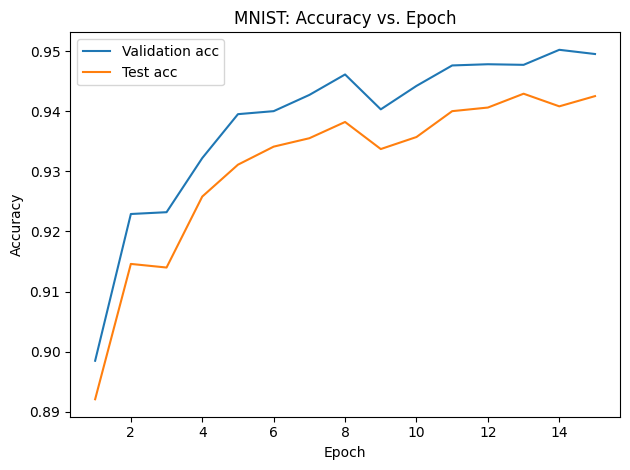

In [7]:
# 1) Load data & build network
training_data, validation_data, test_data = load_data_wrapper()
net = Network([784, 30, 10])

# 2) Train for n epochs, tracking both val & test accuracy
epochs = 15
net.SGD(
    training_data,
    epochs=epochs,
    mini_batch_size=10,
    eta=3.0,
    validation_data=validation_data,
    test_data=test_data
)

# 3) Plot accuracy curves
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, net.validation_accuracies, label='Validation acc')
plt.plot(epochs_range, net.test_accuracies,       label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MNIST: Accuracy vs. Epoch')
plt.legend()
plt.tight_layout()
plt.show()

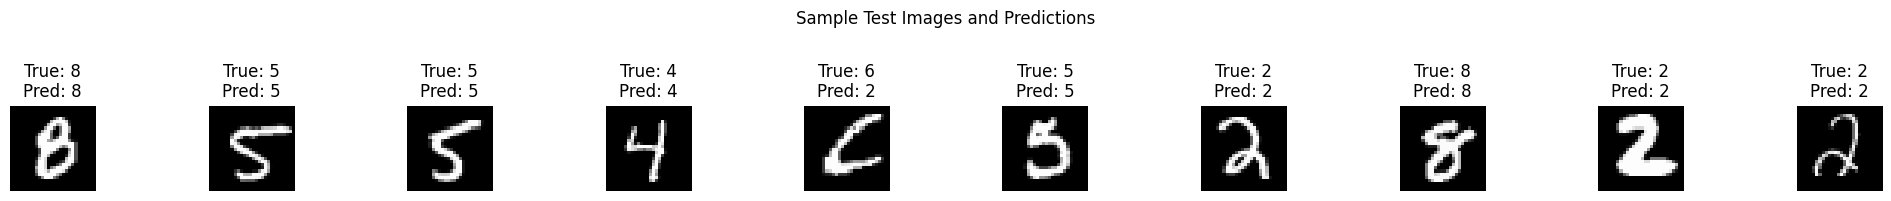

In [8]:
# 4) Display a few test-set examples with predictions
num_examples = 10
examples = random.sample(test_data, num_examples)

plt.figure(figsize=(num_examples*2, 2))
for i, (x, y_true) in enumerate(examples, 1):
    # x is 784×1; reshape back to 28×28
    img = x.reshape(28, 28)
    # network output
    y_pred = np.argmax(net.feedforward(x))

    ax = plt.subplot(1, num_examples, i)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {y_true}\nPred: {y_pred}")
    ax.axis('off')

plt.suptitle("Sample Test Images and Predictions")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()